In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
dataset_path = '../rawBank/bank.csv'
df_tidy = pd.read_csv(dataset_path)

pd.set_option('display.max_columns', None)

In [6]:
def compute_performance_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} F1 Score: {f1_score_value}")

def compute_classification_metric(dataset, predictions, label_name_v, favorable_label_v, unfavorable_label_v, privileged_attribute, unprivileged_attributes):
    features = [privileged_attribute] + unprivileged_attributes

    aif_sex_dataset = BinaryLabelDataset(
            df=dataset,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    aif_sex_pred = BinaryLabelDataset(
            df=predictions,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    sex_privileged_group = [{privileged_attribute: 1}]
    sex_unprivileged_groups = [{attr: 1} for attr in unprivileged_attributes]

    fairness_metrics = ClassificationMetric(dataset=aif_sex_dataset,
                            classified_dataset=aif_sex_pred,
                            unprivileged_groups=sex_unprivileged_groups,
                            privileged_groups=sex_privileged_group)
    
    return fairness_metrics

def compute_fairness_metrics(fairness_metrics: ClassificationMetric):
    # Values less than 0 indicate that privileged group has higher
    # proportion of predicted positive outcomes than unprivileged group.
    # Value higher than 0 indicates that unprivileged group has higher proportion
    # of predicted positive outcomes than privileged group.
    SPD = round(fairness_metrics.statistical_parity_difference(),3)

    # Measures the deviation from the equality of opportunity, which means that the same
    # proportion of each population receives the favorable outcome. This measure must be equal to 0 to be fair.
    EOD = round(fairness_metrics.equal_opportunity_difference(),3)

    # Average of difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups
    # A value of 0 indicates equality of odds, which means that samples in both the privileged and unprivileged
    # groups have the same probability of being classified positively.
    AOD = round(fairness_metrics.average_odds_difference(),3)

    print(f"Statistical Parity Difference (SPD): {SPD}")
    print(f"Equal Opportunity Difference (EOD): {EOD}")
    print(f"Average Odds Difference: {AOD}")

In [7]:
df_tidy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [8]:
print(df_tidy.shape)
df_tidy.info()

(11162, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [9]:
feature_num = df_tidy.select_dtypes(include=['int64', 'float'])
feature_num.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [10]:
feature_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       11162 non-null  int64
 1   balance   11162 non-null  int64
 2   day       11162 non-null  int64
 3   duration  11162 non-null  int64
 4   campaign  11162 non-null  int64
 5   pdays     11162 non-null  int64
 6   previous  11162 non-null  int64
dtypes: int64(7)
memory usage: 610.6 KB


In [11]:
categorize_age = lambda x: 'age<25' if x < 25 else ('25<=age<60' if x < 60 else 'age>=60')
df_tidy['age'] = df_tidy['age'].apply(categorize_age)
df_tidy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,25<=age<60,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,25<=age<60,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,25<=age<60,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,25<=age<60,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,25<=age<60,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [12]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  object
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [13]:
df_tidy[[ 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']].head()

,balance,day,duration,campaign,pdays,previous
0,2343,5,1042,1,-1,0
1,45,5,1467,1,-1,0
2,1270,5,1389,1,-1,0
3,2476,5,579,1,-1,0
4,184,5,673,2,-1,0


In [14]:
df_tidy['deposit'] = df_tidy['deposit'].replace({'yes': 1, 'no': 0})

/var/folders/zy/f73__xyd6mvg23dhh9y1z8wc0000gn/T/ipykernel_21764/1750454383.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tidy['deposit'] = df_tidy['deposit'].replace({'yes': 1, 'no': 0})


In [15]:
categorical_columns = ["age","job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
df_tidy = pd.get_dummies(df_tidy, columns=categorical_columns)
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343,5,1042,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,45,5,1467,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,1270,5,1389,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [16]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
df_tidy[numerical_cols].head()

,balance,day,duration,campaign,pdays,previous,deposit
0,2343,5,1042,1,-1,0,1
1,45,5,1467,1,-1,0,1
2,1270,5,1389,1,-1,0,1
3,2476,5,579,1,-1,0,1
4,184,5,673,2,-1,0,1


In [17]:
numerical_cols = df_tidy.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('deposit')


# Inizializziamo lo StandardScaler
scaler = MinMaxScaler()

# Applichiamo lo scaler solo alle colonne numeriche
df_tidy[numerical_cols] = scaler.fit_transform(df_tidy[numerical_cols])

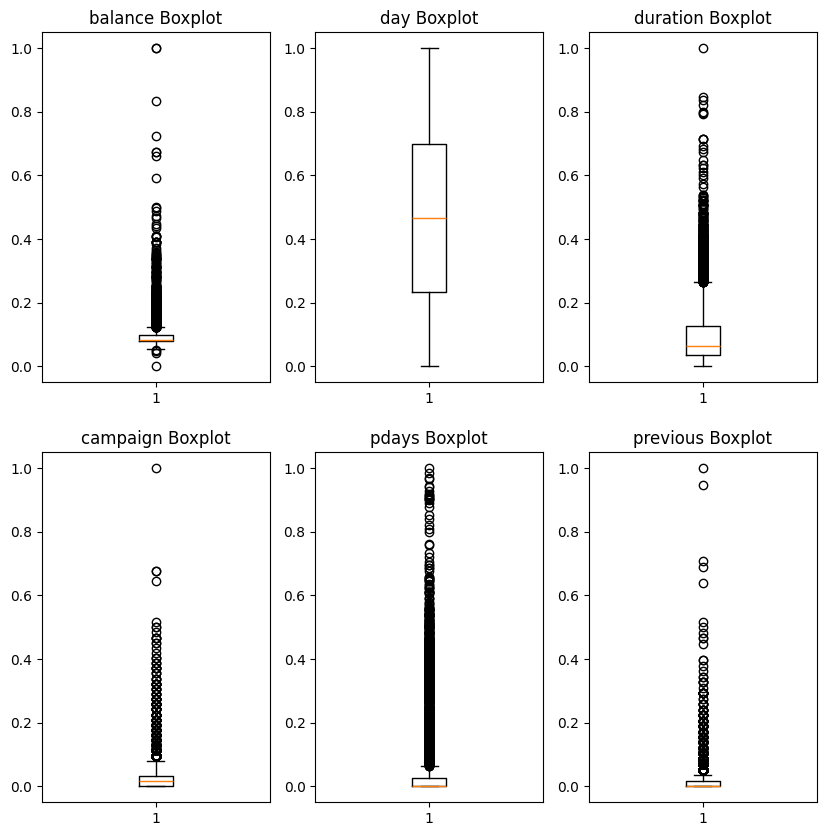

In [18]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [19]:
def calculate_interquartil_interval(column_name):
    Q1 = df_tidy[column_name].quantile(0.25)
    Q3 = df_tidy[column_name].quantile(0.75)

    # Calcolo dell'intervallo interquartile (IQR)
    IQR = Q3 - Q1

    # Determinazione dei limiti inferiore e superiore per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def outliers_count_all(column_names):
    for column in column_names:
        lower_bound, upper_bound = calculate_interquartil_interval(column)
        outliers = df_tidy[(df_tidy[column] < lower_bound) | (df_tidy[column] > upper_bound)]
        print(f"numbers of outliers for {column} column: {outliers.shape[0]}")

def outliers_count(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    outliers = df_tidy[(df_tidy[column_name] < lower_bound) | (df_tidy[column_name] > upper_bound)]
    print(f"numbers of outliers for {column_name} column: {outliers.shape[0]}")
    return outliers.shape[0]

def delete_outlier(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    df_filtered = df_tidy[(df_tidy[column_name] >= lower_bound) & (df_tidy[column_name] <= upper_bound)]
    return df_filtered

In [20]:
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 1056
numbers of outliers for day column: 0
numbers of outliers for duration column: 636
numbers of outliers for campaign column: 601
numbers of outliers for pdays column: 2750
numbers of outliers for previous column: 1258


In [21]:
df_tidy = delete_outlier('balance')
df_tidy = delete_outlier('duration')
df_tidy = delete_outlier('campaign')

In [22]:
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 529
numbers of outliers for day column: 0
numbers of outliers for duration column: 314
numbers of outliers for campaign column: 0
numbers of outliers for pdays column: 839
numbers of outliers for previous column: 1075


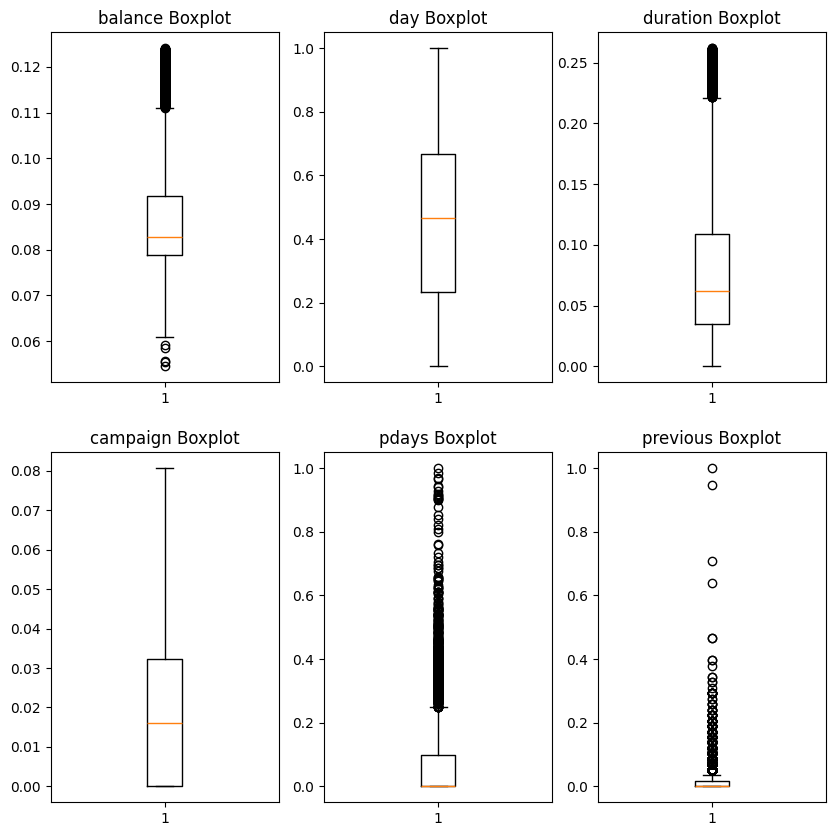

In [23]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [24]:
df_tidy= df_tidy.drop(columns=['pdays', 'previous'])

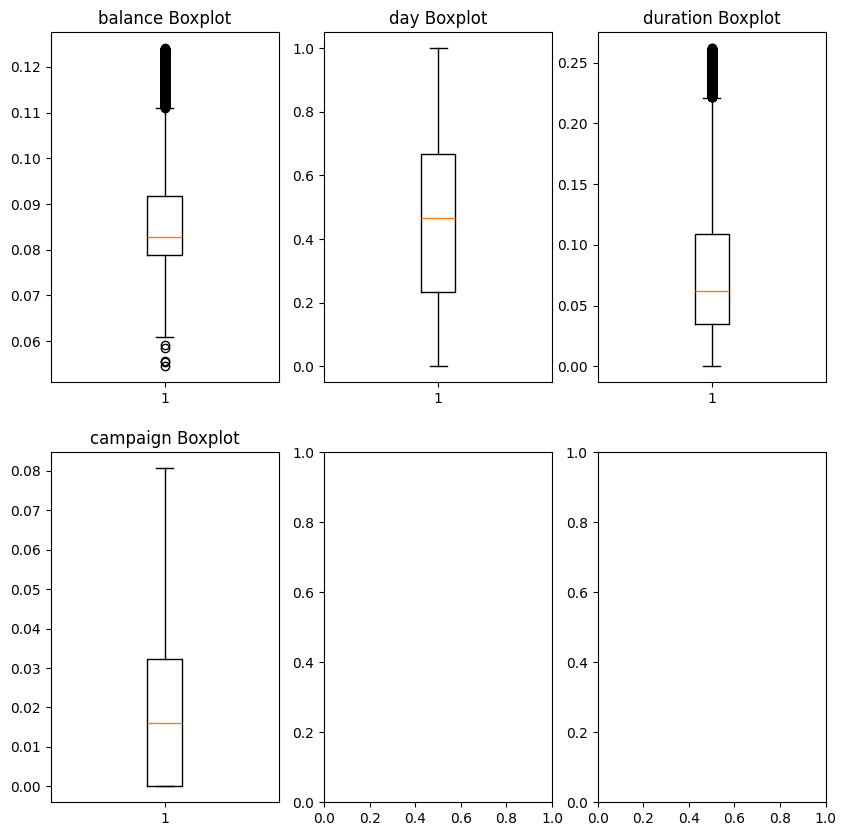

In [25]:
numerical_cols = df_tidy.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('deposit')

#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [26]:
df_tidy.shape

(8997, 52)

In [27]:
while outliers_count('balance') > 0:
    df_tidy = delete_outlier('balance')

while outliers_count('duration') > 0:
    df_tidy = delete_outlier('duration')

numbers of outliers for balance column: 529
numbers of outliers for balance column: 382
numbers of outliers for balance column: 192
numbers of outliers for balance column: 133
numbers of outliers for balance column: 98
numbers of outliers for balance column: 49
numbers of outliers for balance column: 36
numbers of outliers for balance column: 18
numbers of outliers for balance column: 9
numbers of outliers for balance column: 7
numbers of outliers for balance column: 4
numbers of outliers for balance column: 2
numbers of outliers for balance column: 8
numbers of outliers for balance column: 7
numbers of outliers for balance column: 7
numbers of outliers for balance column: 11
numbers of outliers for balance column: 16
numbers of outliers for balance column: 11
numbers of outliers for balance column: 9
numbers of outliers for balance column: 3
numbers of outliers for balance column: 6
numbers of outliers for balance column: 1
numbers of outliers for balance column: 0
numbers of outliers

In [28]:
df_tidy.shape

(6875, 52)

In [29]:
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 13
numbers of outliers for day column: 0
numbers of outliers for duration column: 0
numbers of outliers for campaign column: 0


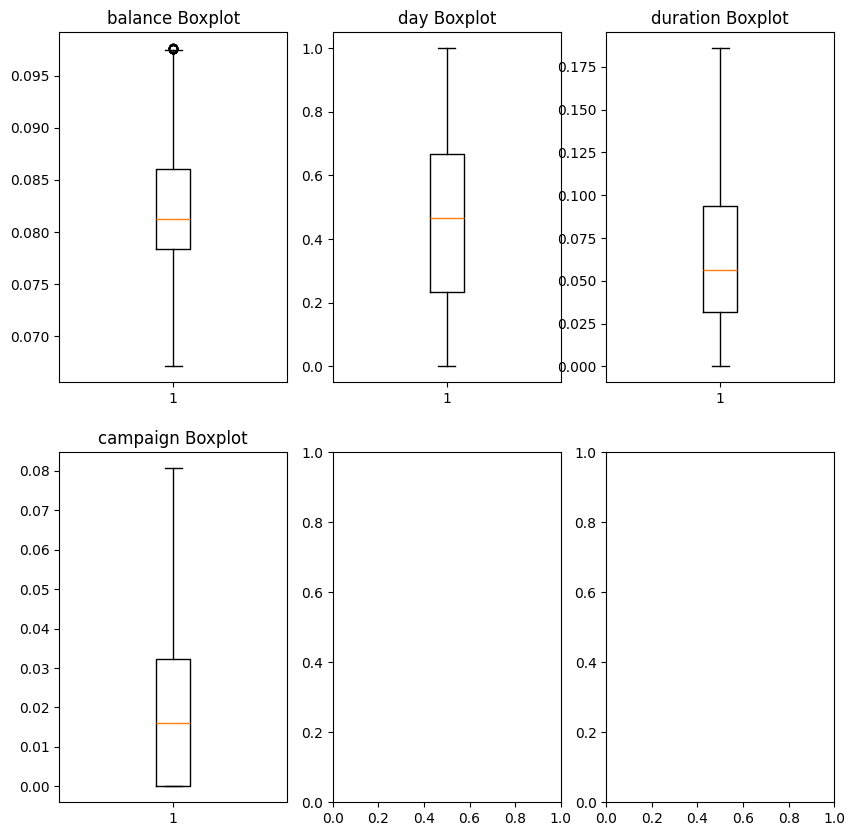

In [30]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [31]:
df_tidy.to_csv("bankTrainedTidy.csv", index=False)

In [32]:
X = df_tidy.drop(columns="deposit")
y = df_tidy["deposit"]

# Define four sets and apply the function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 0.2 indicates a test set size of 20%
                                                    random_state=42)

In [33]:
dt_clf = DecisionTreeClassifier(random_state=42)

# The fit function will do the trick
dt_clf.fit(X_train, y_train)

# After the training phase, the model will be tested by predicting the values on the test set
dt_predictions = dt_clf.predict(X_test)

compute_performance_metrics(y_test,dt_predictions,"Decision Tree")

Decision Tree Accuracy: 0.7803636363636364
Decision Tree Recall: 0.7213114754098361
Decision Tree F1 Score: 0.7239488117001828


In [34]:
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Addestro il classificatore sui dati di training
svm_classifier.fit(X_train, y_train)

# predizioni sui dati di test
svm_pred = svm_classifier.predict(X_test)

compute_performance_metrics(y_test,svm_pred,"SVM")

SVM Accuracy: 0.8261818181818181
SVM Recall: 0.7340619307832422
SVM F1 Score: 0.7712918660287081


In [35]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth = None, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

compute_performance_metrics(y_test,rf_predictions,"Random Forest")

Random Forest Accuracy: 0.8458181818181818
Random Forest Recall: 0.7595628415300546
Random Forest F1 Score: 0.7973231357552581


In [36]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO IL DECISION TREE
dataset = X_test.copy(deep=True) # we create a copy of the test set
dataset['deposit'] = y_test  # and join the target feature with the others
predictions = dataset.copy(deep=True) # we do the same task
predictions['deposit'] = dt_predictions # but this time the target feature is made by the predictions of our model

In [37]:
#Attributo privilegiato la colonna age tra 25 e 59
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.453
Equal Opportunity Difference (EOD): 0.167
Average Odds Difference: 0.308


In [38]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO L'SVM
dataset = X_test.copy(deep=True)
dataset['deposit'] = y_test
predictions = dataset.copy(deep=True) 
predictions['deposit'] = svm_pred

In [39]:
#Attributo privilegiato la colonna age tra 25 e 59
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.554
Equal Opportunity Difference (EOD): 0.287
Average Odds Difference: 0.324


In [40]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO Il Random Forest
dataset = X_test.copy(deep=True)
dataset['deposit'] = y_test
predictions = dataset.copy(deep=True) 
predictions['deposit'] = rf_predictions

In [41]:
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.562
Equal Opportunity Difference (EOD): 0.281
Average Odds Difference: 0.309
